## Makemore Part 3

In [1]:
import sys
!{sys.executable} -m pip install ipywidgets
!{sys.executable} -m pip install scipy


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.6/libexec/bin/python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.6/libexec/bin/python -m pip install --upgrade pip


In [28]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [29]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [30]:
len(words)

32033

In [31]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [82]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182778, 8]) torch.Size([182778])
torch.Size([22633, 8]) torch.Size([22633])
torch.Size([22735, 8]) torch.Size([22735])


In [83]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print (''.join(itos[ix.item()] for ix in x), '-->' , itos[y.item()])

........ --> e
.......e --> m
......em --> m
.....emm --> a
....emma --> .
........ --> o
.......o --> l
......ol --> i
.....oli --> v
....oliv --> i
...olivi --> a
..olivia --> .
........ --> a
.......a --> v
......av --> a
.....ava --> .
........ --> i
.......i --> s
......is --> a
.....isa --> b


In [116]:

### ---------------------------------------- Linear Layer ----------------------------------------------------------
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # Kaiming initialization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

### ------------------------------------------------------------------------------------------------------------------

### ---------------------------------------------------------- BatchNormID Layer ------------------------------------------
class BatchNorm1d: # check batchnorm1D from Pytorch documentation 

    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # is used because, modules can have different behaviour when training vs when in evaluation mode or during inference 
        # parameters (trained with backprop)

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass --> check the paper for the algorithm
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True, unbiased=True) # batch variance

        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/ torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers

        if self.training:
            with torch.no_grad(): # don't need the computational graph 
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean # exponential moving average
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

### ------------------------------------------------------------------------------------------------------------------------

### -------------------------------------------- Non-Linearity (Tanh) Layer ------------------------------------------------
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

### ------------------------------------------------------------------------------------------------------------------------

### -------------------------------------------------- Embedding --------------------------------------------------------

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self,IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

### ---------------------------------------------------------------------------------------------------------------------

### ------------------------------------------------- Flatten ----------------------------------------------------------

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self,x):
        B, T , C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

### ---------------------------------------------------------------------------------------------------------------------------

### ----------------------------------------------------- Sequential ---------------------------------------------------------

class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

### -------------------------------------------------------------------------------------------------------------------------

In [117]:
torch.manual_seed(42); # seed rng for reproduciblity

In [129]:
n_embd = 24 # the dimensionality of the character embeddings vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP


model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameter in total

for p in parameters:
    p.requires_grad = True


76579


In [130]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at a batch of just 4 examples

Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  1, 12,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 11,  1,  5],
        [ 0,  0,  0,  0, 19,  1, 20, 15]])

In [131]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [132]:
model.layers[0].out.shape # output of the Embedding layer

torch.Size([4, 8, 24])

In [133]:
model.layers[1].out.shape # output of Flatten layer

torch.Size([4, 4, 48])

In [134]:
model.layers[2].out.shape # output of the Linear Layer

torch.Size([4, 4, 128])

In [135]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [136]:
(torch.randn(4,4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [137]:
(torch.randn(4,4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [138]:
# (1 2) (3 4) (5 6) (7 8) 

list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [139]:
e = torch.randn(4, 8, 10) # goal -> want this to be (4, 4, 20) where consecutive 10-d vectors get concatenated
torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2).shape

torch.Size([4, 4, 20])

In [140]:
# OR use view 

e.view([4, 4, 20]).shape

torch.Size([4, 4, 20])

In [141]:
# same optimization as last time -->  Read the batch normalization paper
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())



      0/ 200000: 3.4490
  10000/ 200000: 1.8173
  20000/ 200000: 2.1704
  30000/ 200000: 2.1658
  40000/ 200000: 1.8145
  50000/ 200000: 2.0538
  60000/ 200000: 2.1143
  70000/ 200000: 2.3660
  80000/ 200000: 1.5669
  90000/ 200000: 1.8598
 100000/ 200000: 1.9696
 110000/ 200000: 1.7486
 120000/ 200000: 1.9348
 130000/ 200000: 1.7029
 140000/ 200000: 1.6754
 150000/ 200000: 2.1745
 160000/ 200000: 2.0531
 170000/ 200000: 2.1529
 180000/ 200000: 2.0086
 190000/ 200000: 1.8412


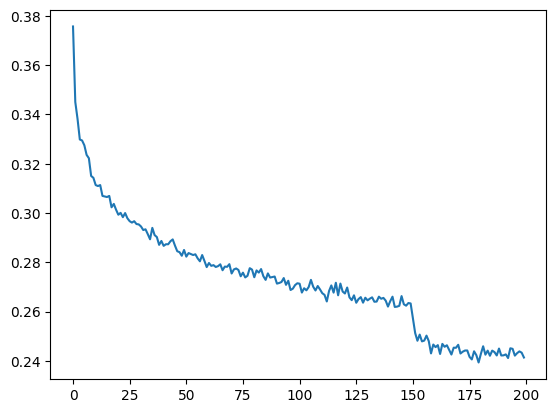

In [142]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [143]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [144]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print (split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.7263418436050415
val 2.2407066822052


In [114]:
## with new architecture without the hidden issue in BatchNorm
## FLAT --> Heirarchical (22k params) -> Train 1.89 and Val: 2.25
## FIX BUG in BATCHNORM -> Train: 1.83     , Val: 2.29
## Scale up the network: nembd 24, n_hidden 128 (76K params) --> Tain: 1.72 , Val: 2.24

In [145]:
# sample from the model 

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net  
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

oaklyn.
santine.
allaya.
kylen.
sakaiah.
rhylin.
ayanna.
oswaldou.
taylyn.
andria.
obidea.
neeve.
remilyne.
kaydyn.
yukynn.
brooklynn.
kasim.
kyrielle.
fredrick.
maleezah.
